In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [3]:
# Circuit
Rs =   1e+4 # Ω
RL = 2*13.2 # Ω

# Parameters
Δt = 1.0e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
a, b = 2.00, 0.08
n, m = 100, 4
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function dof_type(n, m)
    global NUM_EDGES
    N = NUM_EDGES
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    dof_flag = zeros(Int64, N)
    
    dof_flag[(h[1])] .= DOF_PEC # BOTTOM
    dof_flag[(h[3])] .= DOF_PEC # MIDDLE
    dof_flag[(h[5])] .= DOF_PEC # TOP
    
    dof_flag[first(v[1])] = DOF_SRC
    dof_flag[first(v[2])] = DOF_SRC
    
    dof_flag[first(v[3])] = DOF_SG
    dof_flag[first(v[4])] = DOF_SG
    
    dof_flag[ last(v[1])] = DOF_LOAD
    dof_flag[ last(v[2])] = DOF_LOAD
    dof_flag[ last(v[3])] = DOF_LOAD
    dof_flag[ last(v[4])] = DOF_LOAD
    
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

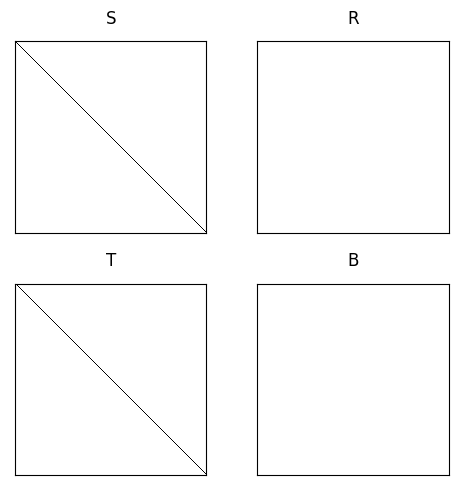

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [10]:
sigmoid(x) = 1.0 / (1.0 + exp(-2x))
Rsp(t, tswitch) = 1e15 - 1e15sigmoid(t - tswitch) + 6e-1

function assemble_circuit!(P, C, G, t)
    for ii = 1:NUM_EDGES
      if Γ[ii] == DOF_LOAD
        len = ly
        G[dof[ii], dof[ii]] = μ0 * len^2 / RL * (b / len)
      end

      if Γ[ii] == DOF_SG
        len = ly
        G[dof[ii], dof[ii]] = μ0 * len^2 / Rsp(1e9t, 15_000) * (b / len)
      end

      if Γ[ii] == DOF_SRC
        len = ly
        G[dof[ii], dof[ii]] = μ0 * len^2 / Rs * (b / len)
      end
    end
end

assemble_circuit! (generic function with 1 method)

In [11]:
x = 0.010:0.050:0.51
y = 0.005:0.012:0.07
xx, yy = meshgrid(x, y);

it  = 1
nt  = 16_000
t   = 0.00
e   = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vRsg = zeros(nt)
vRL  = zeros(nt)
nothing

In [12]:
function current(t)
    if t < 20e-9
        return 1.0
    end
    return 0.0
end

P = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / L
G = spzeros(NUM_DOFS, NUM_DOFS) # μ0 / R
C = spzeros(NUM_DOFS, NUM_DOFS) # μ0 * C

assemble_circuit!(P, C, G, 0.0)
Ppp, Pp = copy(P), copy(P)
Cpp, Cp = copy(C), copy(C)
Gpp, Gp = copy(G), copy(G)

function shift!(xpp, xp, x)
    xpp .= xp; xp .= x
end

@elapsed for _ = it:nt
    assemble_circuit!(P, C, G, t)
    Ai = (+0.25Δt^2 * P +  C + 0.5Δt * G)
    bi = (-0.25Δt^2 * S -  T + 0.5Δt * B + 0.5Δt * R) * epp +
         (-0.50Δt^2 * S + 2T) * ep +
         (-0.25Δt^2 * Ppp -  Cpp + 0.5Δt * Gpp) * epp +
         (-0.50Δt^2 * Pp  + 2Cp) * ep
         
    bbi = zeros(NUM_EDGES)
    for ii = 1:NUM_EDGES
      if Γ[ii] == DOF_SRC
            len = ly
            bbi[dof[ii]] = len^2 * current(t) / Rs
      end
    end
    
    e   .= (A + Ai) \ (bi + μ0 * Δt * bbi)
    
    shift!(epp, ep, e)
    shift!(Ppp, Pp, P)
    shift!(Cpp, Cp, C)
    shift!(Gpp, Gp, G)

    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vRsg[it] = sum(e[dof[Γ .== DOF_SG]])
    vRL[it]  = sum(e[dof[Γ .== DOF_LOAD]])


    it += 1
    t  += Δt
end

23.169543405

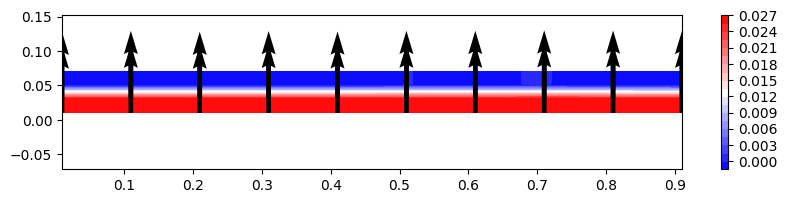

PyObject <matplotlib.quiver.Quiver object at 0x7fa2a6f6c210>

In [13]:
x = 0.01:0.10:1.00
y = 0.01:0.02:0.08
E = evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(10, 2))
contourf(xx', yy', E[:, :, 2], cmap=PyPlot.get_cmap("bwr"), levels=20)
axis("equal"); colorbar();
quiver(xx', yy', E[:, :, 1], E[:, :, 2])

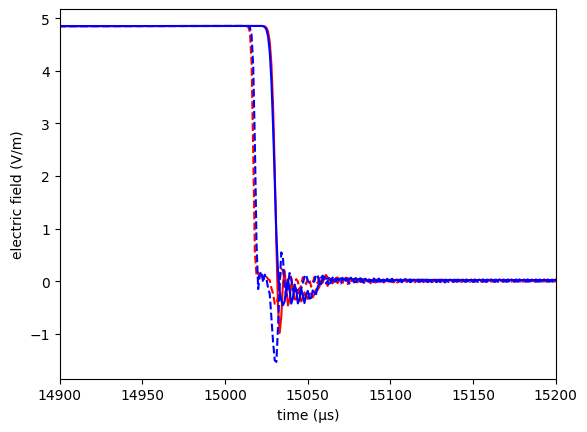

PyObject Text(24.000000000000007, 0.5, 'electric field (V/m)')

In [14]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 2], "r-")
plot(ts,-res[:, 3, 6, 2], "r--")
plot(ts, res[:, 9, 1, 2], "b-")
plot(ts,-res[:, 9, 6, 2], "b--")
xlim([14900, 15200])
xlabel("time (μs)")
ylabel("electric field (V/m)")

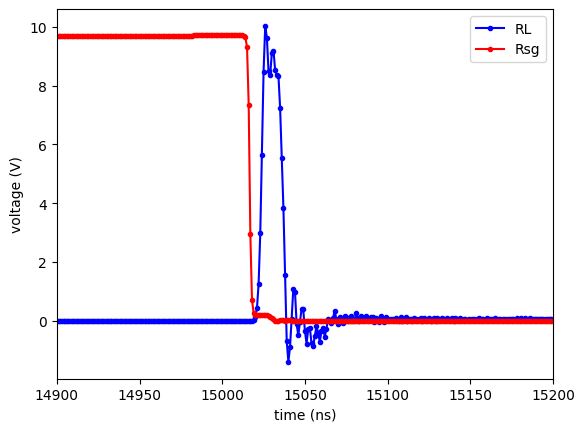

(14900, 15200)

In [15]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
plot(ts, vRL, "b.-")
plot(ts,-vRsg, "r.-")
ylabel("voltage (V)")
legend(["RL", "Rsg"])
xlim([14900, 15200])